# RQ 5 (Motivation)

> What are the most prevalent use cases for unsafe code?

## Use Case 5: Foreign Functions

### Query 12

> we count *how many types are equipped with #[repr(C)]*.

### Query 13

> We thus classify *all -sys crates* as belonging to this use case.

### Query 14

> we determine *how many unsafe functions are declared with a foreign ABI*.

### Query 15

> we search for *usages of inline assembly* via the asm! macro.

## Use Case 6: Performance

### Query 16

> we *search for unchecked functions* (those with "unchecked" in their name).

### Query 17

> we determine whether *unsafe blocks contain the special union type MaybeUninit*


## Setup

In [1]:
# import libraries
import itertools
import functools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree

import utils
import top_crates
from whitelists import *
from drawing import *

# Configure pyplot: enlarge plots 
plt.rcParams['figure.figsize'] = [15, 8]
# Configure pandas: show all columns when printing a dataframe
pd.set_option('display.max_columns', None)
# Configure pandas: show more rows when printing a dataframe
pd.set_option('display.min_rows', 20)

In [2]:
# Load tables
function_definitions = utils.load_selected_function_definitions()
raw_function_unsafe_reasons = utils.load_unsafe_reasons_in_function_definitions()
unsafe_block_calls = utils.load_unsafe_block_calls()
const_calls = utils.load_const_calls()
unsafe_blocks = utils.load_unsafe_blocks()
traits = utils.load_selected_traits()
traits_impls = utils.load_selected_impl_definitions()
type_defs = utils.load_selected_type_defs()
adts = utils.load_selected_adts()
adt_field_types = utils.load_selected_adt_field_types()

Note:
* `function_definitions` contain the function definition from our selected list of crates.
* `raw_function_unsafe_reasons` contain unsafety reasons for potentially **any** function.
As a result, the set of functions mentioned in each relation are incomparable.

In [3]:
# Validation
for crate in trusted_crate_names:
   assert len(function_definitions[function_definitions.crate == crate]) > 0
assert function_definitions[function_definitions.unsafety == "Unknown"].abi.unique() == ["Closure"]

# Cleanup: remove duplicates
raw_function_unsafe_reasons = raw_function_unsafe_reasons.drop_duplicates()

# Remove functions that are not in function_definitions
raw_function_unsafe_reasons = raw_function_unsafe_reasons[
    raw_function_unsafe_reasons.def_path.isin(set(function_definitions.def_path.unique()))
]
assert len(raw_function_unsafe_reasons) > 10000

possible_unsafe_reasons = [
    "call to unsafe function",
    "use of inline assembly",
    "initializing type with `rustc_layout_scalar_valid_range` attr",
    "cast of pointer to int",
    "pointer operation",
    "borrow of packed field",
    "use of mutable static",
    "use of extern static",
    "dereference of raw pointer",
    "assignment to non-`Copy` union field",
    "access to union field",
    "mutation of layout constrained field",
    "borrow of layout constrained field with interior mutability",
]

# Validation
assert not raw_function_unsafe_reasons.duplicated().any()
assert set(raw_function_unsafe_reasons.unsafe_reason.unique()).issubset(possible_unsafe_reasons)
assert function_definitions[function_definitions.unsafety == "Unknown"].abi.unique() == ["Closure"]

In [4]:
# Augment const calls made from unsafe blocks
unsafe_block_const_calls = unsafe_block_calls.join(
    const_calls.set_index("call"),
    on="call",
    how="inner",
    rsuffix="_defsite",
)
# Rename confusing columns
unsafe_block_const_calls.rename(
    columns={"crate_name": "crate_callsite", "crate": "crate_defsite"},
    inplace=True
)

# Preprocessing
unsafe_function_definitions = function_definitions[function_definitions.unsafety == "Unsafe"]

# Validation
assert len(unsafe_block_const_calls.query("crate_defsite == crate_callsite")) > 0
assert len(unsafe_block_const_calls.query("crate_defsite != crate_callsite")) > 0

In [5]:
# Whitelists
all_function_names = set(function_definitions.def_path.unique())
unchecked_function_names = get_unchecked_function_names(all_function_names)

# Validation
assert "std" in function_definitions.crate.unique()

## Reasons for Unsafety in the Rust Compiler

> we first identified a set of independent reasons why the compiler requires unsafe blocks
and functions to be declared unsafe. We extracted these reasons from the source code of the Rust
compiler [Rust Team 2020a]. 

In [6]:
# Check frequency of values in the "unsafety" and "visibility" columns
print(raw_function_unsafe_reasons.unsafe_reason.value_counts())

call to unsafe function                                          438044
dereference of raw pointer                                        46328
use of mutable static                                             25888
access to union field                                              1426
use of extern static                                                548
use of inline assembly                                              493
borrow of packed field                                              326
initializing type with `rustc_layout_scalar_valid_range` attr        41
assignment to non-`Copy` union field                                  3
pointer operation                                                     2
cast of pointer to int                                                1
Name: unsafe_reason, dtype: int64


In [7]:
function_unsafe_reasons = raw_function_unsafe_reasons[
    ["crate_name", "crate_hash", "def_path", "unsafe_reason"]
].groupby("def_path").agg(frozenset).rename(
    columns={'unsafe_reason': 'unsafe_reasons'}
)

function_unsafe_reasons["unsafe_reasons_vec"] = function_unsafe_reasons.unsafe_reasons.map(
    lambda x: [reason in x for reason in possible_unsafe_reasons]
)
function_unsafe_reasons["num_unsafe_reasons"] = function_unsafe_reasons.unsafe_reasons_vec.map(sum)

for reason in possible_unsafe_reasons:
    function_unsafe_reasons[reason] = function_unsafe_reasons.unsafe_reasons.map(
        lambda x: reason in x
    )

#### Results from the paper for comparison (Table 3)

> Then, we collected which reasons apply to the implementation of
each function (either the body of an unsafe function or the unsafe blocks inside a safe function).

![Table 3](pics/reasons-why-unsafe.png)


call to unsafe function                                          437901
dereference of raw pointer                                        46264
use of mutable static                                             25888
access to union field                                              1426
use of extern static                                                548
use of inline assembly                                              493
borrow of packed field                                              326
initializing type with `rustc_layout_scalar_valid_range` attr        41
assignment to non-`Copy` union field                                  3
pointer operation                                                     2
cast of pointer to int                                                1
borrow of layout constrained field with interior mutability           0
mutation of layout constrained field                                  0
dtype: int64
call to unsafe function                            

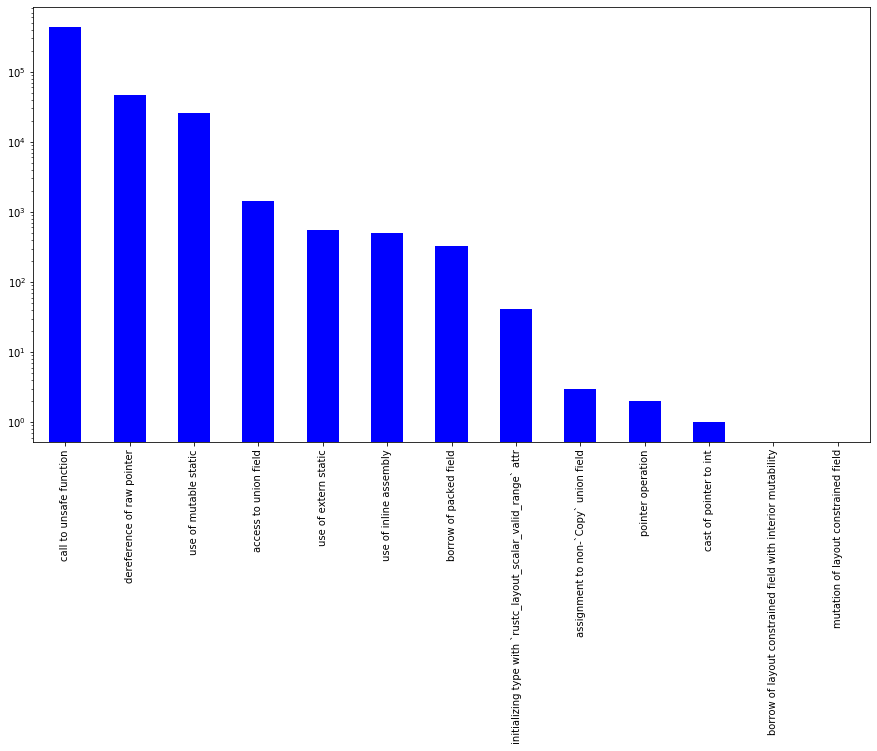

In [8]:
# Frequency of each reason
values = function_unsafe_reasons[possible_unsafe_reasons].apply(sum).sort_values(ascending=False)
function_count = len(pd.unique(raw_function_unsafe_reasons['def_path']))
print(values)
print(values/function_count*100)
values.plot.bar(
    legend=False,
    color=['b'],
    logy=True,
);
del values

#### Results from the paper for comparison

> A block or function may be unsafe for multiple reasons. We found that for 84.6% of all functions that have at least one reason of unsafety, calling unsafe functions is the only reason of unsafety. In 94.0% of the functions, unsafety is due only to the first 2 entries of the table, and that in 99.4% of the functions, all reasons for unsafety are among the top 3 entries of the table.


In [9]:
# Distribution of number of reasons
function_unsafe_reasons.num_unsafe_reasons.value_counts()

1    455165
2     28567
3       194
4         3
Name: num_unsafe_reasons, dtype: int64

In [10]:
# Find the features that cover as much situations as possible
if False:
    print(max([
        (
            sum(function_unsafe_reasons.unsafe_reasons.map(lambda x: x.issubset(reasons))) / len(function_unsafe_reasons),
            reasons
        )
        for reasons in itertools.combinations(possible_unsafe_reasons, r=1)
    ]))
    print(max([
        (
            sum(function_unsafe_reasons.unsafe_reasons.map(lambda x: x.issubset(reasons))) / len(function_unsafe_reasons),
            reasons
        )
        for reasons in itertools.combinations(possible_unsafe_reasons, r=2)
    ]))

    print(max([
        (
            sum(function_unsafe_reasons.unsafe_reasons.map(lambda x: x.issubset(reasons))) / len(function_unsafe_reasons),
            reasons
        )
        for reasons in itertools.combinations(possible_unsafe_reasons, r=3)
    ]))

# Cached results
print("(0.8464526821083258, ('call to unsafe function',))")
print("(0.9406772481087101, ('call to unsafe function', 'dereference of raw pointer'))")
print("(0.994152034699305, ('call to unsafe function', 'use of mutable static', 'dereference of raw pointer'))")

(0.8464526821083258, ('call to unsafe function',))
(0.9406772481087101, ('call to unsafe function', 'dereference of raw pointer'))
(0.994152034699305, ('call to unsafe function', 'use of mutable static', 'dereference of raw pointer'))


## Use Case 1: Data structures with complex sharing

### Query 7

> collect *all functions that contain a dereference of a raw pointer*

#### Results from the paper for comparison

> Our database contains 7,385,689 function definitions, out of which only 46,264 (0.6%) dereference a raw pointer in their implementation.

In [11]:
print("all_function_names:", len(all_function_names))

# Validation
assert set(function_unsafe_reasons[function_unsafe_reasons["dereference of raw pointer"]].index).issubset(all_function_names)

print("functions that deref. a raw pointer:",
      sum(function_unsafe_reasons["dereference of raw pointer"]),
      100 * sum(function_unsafe_reasons["dereference of raw pointer"]) / len(all_function_names))

all_function_names: 7385689
functions that deref. a raw pointer: 46264 0.6264005971548491


#### Results from the paper for comparison

> In particular, this is done in 9,273 out of a total of 557,380 unsafe functions (1.7%), in 35,761 out of 6,221,052 safe functions (0.6%), and in 1,230 of 607,257 closure declarations (0.2%).

In [12]:
all_unsafe_function_names = set(unsafe_function_definitions.def_path.unique())
all_safe_function_names = set(function_definitions[function_definitions.unsafety == "Normal"].def_path.unique())
all_closure_names = set(function_definitions[function_definitions.unsafety == "Unknown"].def_path.unique())
assert len(all_unsafe_function_names) > 0
assert len(all_safe_function_names) > 0
assert len(all_closure_names) > 0

print("all_unsafe_function_names:", len(all_unsafe_function_names))
print("all_safe_function_names:", len(all_safe_function_names))
print("all_closure_names:", len(all_closure_names))

count1 = sum(function_unsafe_reasons[
    function_unsafe_reasons.index.isin(all_unsafe_function_names)
]["dereference of raw pointer"])
print("unsafe functions that deref. a raw pointer:", count1, 100 * count1 / len(all_unsafe_function_names))

count2 = sum(function_unsafe_reasons[
    function_unsafe_reasons.index.isin(all_safe_function_names)
]["dereference of raw pointer"])
print("safe functions that deref. a raw pointer:", count2, 100 * count2 / len(all_safe_function_names))

count3 = sum(function_unsafe_reasons[
    function_unsafe_reasons.index.isin(all_closure_names)
]["dereference of raw pointer"])
print("closures that deref. a raw pointer:", count3, 100 * count3 / len(all_closure_names))

assert count1 + count2 + count3 == sum(function_unsafe_reasons["dereference of raw pointer"])

del count1, count2, count3

all_unsafe_function_names: 557380
all_safe_function_names: 6221052
all_closure_names: 607257
unsafe functions that deref. a raw pointer: 9273 1.6636764864186013
safe functions that deref. a raw pointer: 35761 0.5748384678347006
closures that deref. a raw pointer: 1230 0.20255015586481506


> Overall, 7.0% of all crates have unsafe code that dereferences at least one raw pointer. Regarding the raw
pointer fields, we found that 6.6% of all crates have types with raw pointer fields. After filtering out
raw pointers in structs whose attributes indicate that they are likely intended for interoperability,
this number reduces to 4.6% of all crates.

In [13]:
selected_builds = utils.load_selected_builds()
non_tree_adts = utils.load_non_tree_adts()

In [14]:
dereference_crate_count = len(function_unsafe_reasons[
    function_unsafe_reasons["dereference of raw pointer"]].crate_hash.unique())
print('Crates dereferencing raw pointers: ',
      100 * dereference_crate_count/len(selected_builds))

Crates dereferencing raw pointers:  7.026077133084382


In [15]:
non_tree_builds = len(pd.unique(non_tree_adts['build']))
non_c_non_tree_adts = non_tree_adts.query('not c_repr')
non_c_non_tree_builds = len(pd.unique(non_c_non_tree_adts['build']))
print('builds with data structures having raw pointer fields (all):', non_tree_builds)
print('proportion: {:.2f}'.format(100 * non_tree_builds/len(selected_builds)))
print('builds with data structures having raw pointer fields (excluding repr(C)):', non_c_non_tree_builds)
print('proportion: {:.2f}'.format(100 * non_c_non_tree_builds/len(selected_builds)))

builds with data structures having raw pointer fields (all): 2087
proportion: 6.55
builds with data structures having raw pointer fields (excluding repr(C)): 1470
proportion: 4.61


## Use Case 2: Incompleteness Issues

### Query 8

> collect *all calls of unsafe functions involving explicit type casts*


In [16]:
print("unsafe_blocks:", len(unsafe_blocks))
print("total crates:", len(selected_builds.crate_hash.unique()))
assert len(selected_builds) == len(selected_builds.crate_hash.unique())

unsafe_blocks: 674999
total crates: 31867


#### Results from the paper for comparison

> We found that 28,469 out of 674,999 unsafe blocks (4.2%) call a transmute function, and that 4.5% of all crates contain at least one call to a transmute function. Interestingly, only 1.7% of all crates have more than 3 unsafe blocks with a call to those functions.


In [17]:
# Find the unsafe blocks (and crates) that statically call transmute or transmute_copy
blocks = unsafe_block_const_calls[
    unsafe_block_const_calls.def_path.isin(set([
        'core[e667]::intrinsics[0]::[1]::transmute[0]',
        'core[e667]::mem[0]::transmute_copy[0]',
    ]))
][
    ["crate_callsite", "build_crate_hash", "unsafe_scope"]
].drop_duplicates()
print("blocks", len(blocks), len(unsafe_blocks), 100 * len(blocks) / len(unsafe_blocks))
print()
print("crates", len(blocks.build_crate_hash.unique()),
      100 * len(blocks.build_crate_hash.unique()) / len(selected_builds.crate_hash.unique()))
data = pd.value_counts(blocks.crate_callsite)
print(data)
print(sum(data > 3), 100 * sum(data > 3) / len(selected_builds.crate_hash.unique()))
print()
print("With 1000+ unsafe blocks:")
for crate, count in data[data >= 1000].iteritems():
    print("* {} {}: https://crates.io/crates/{}".format(count, crate, crate))
del blocks, data

blocks 28469 674999 4.217635877979078

crates 1421 4.4591583770044245
imgui_ext                       3636
esp_idf_sys                     3045
gtk                             1176
gdnative_bindings               1170
rbspy_ruby_structs              1152
packed_simd                     1121
raw_serde                        781
rute                             676
bobbin_bits                      649
webkit2gtk_webextension          578
                                ... 
lru2                               1
stb_truetype_bugfix_19072017       1
astral_util                        1
rbpf                               1
next_gen                           1
digest_hash                        1
argon2                             1
aurelius                           1
yaks                               1
ebpf                               1
Name: crate_callsite, Length: 1398, dtype: int64
536 1.6819907741550821

With 1000+ unsafe blocks:
* 3636 imgui_ext: https://crates.io/crates/imgui_ext
*

#### Manual analysis of the crates that call transmute from 1000+ unsafe blocks
* 3636 `imgui_ext`: The `imgui_drag_scalar` and `imgui_drag_matrix` macros defined in `imgui-ext/src/macros.rs` are recursive and call `transmute` multiple times each time. Each call to `imgui_drag_matrix`, in particular, results in a cubic number of instantiations: proportional to the length of its first parameter, to the value of the second and to the value of the third parameter.
* 3045 `esp_idf_sys`: The `esp-idf-sys/src/bindings.rs` file is automatically generated and contains 3000+ calls to `transmute`.
* 1176 `gtk`: The files under `gtk/src/auto/` are automatically generated. Each of 150+ of those files contains from a few to 100 calls to `transmute`.
* 1170 `gdnative_bindings`: As the name and description of the crate say, all the code in the crate is automatically generated.
* 1152 `rbspy_ruby_structs`: For each of 38 different versions of Ruby there is a file in `src/` responsible for from 8 to 87 calls to `transmute`. These files provide bindings for various internal Ruby structions for version `1.9.3` to `2.5.0`.
* 1121 `packed_simd`: This crate offers functions to work with SIMD vector types. Many of its macros use `transmute`, for example the `impl_unary` macro that is called 343 times.

## Use Case 3: Emphasize Contracts and Invariants

### Query 9

> we *search for unsafe functions whose body contains only safe Rust code*

#### Results from the paper for comparison

> Regarding unsafe functions, our experiments yield that 36% of all unsafe functions are written
in completely safe Rust.


36.1% of the unsafe functions don't actually need to be unsafe


300563

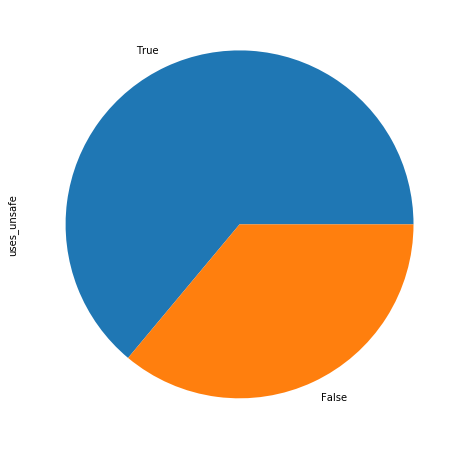

In [18]:
# Method 1
unsafe_rust_functions = unsafe_function_definitions[
    unsafe_function_definitions.abi == "Rust"
]
values = unsafe_rust_functions.uses_unsafe.value_counts()
values.plot.pie()
print("{:.1%} of the unsafe functions don't actually need to be unsafe".format(
    sum(~unsafe_rust_functions.uses_unsafe) / len(unsafe_rust_functions)
))
len(unsafe_rust_functions)

> To find explanations for the surprisingly high number of unsafe functions with safe implementations, we performed manual inspections: We manually inspected the ten crates with the highest
overall count of unsafe functions with completely safe bodies. All of these crates are automatically
generated to provide peripheral access to various microcontrollers.

In [19]:
# Show examples of unsafe functions that don't need to be unsafe
impostor_unsafe_function_definitions = unsafe_rust_functions[
    ~unsafe_rust_functions.uses_unsafe
    & (unsafe_rust_functions.visibility == "Public")
]

print("Examples of unsafe functions that don't need to be unsafe:")
for f in impostor_unsafe_function_definitions.def_path.sample(10):
    print("*", f)

Examples of unsafe functions that don't need to be unsafe:
* atsams70q19b[d4e3]::pwm0[0]::pwm_ier1[0]::{{impl}}[9]::bits[0]
* cc13x2_cc26x2_hal[3ef7]::aux_tdc[0]::precntr[0]::{{impl}}[3]::bits[0]
* id3[59df]::stream[0]::frame[0]::v4[0]::{{impl}}[14]::from_bits_unchecked[0]
* s32k144[5167]::dma[0]::tcd3_csr[0]::{{impl}}[24]::bits[0]
* imxrt1062_romc[5acf]::rompatchenl[0]::{{impl}}[3]::bits[0]
* cc13x2_cc26x2_pac[78a3]::gpt3[0]::taps[0]::{{impl}}[6]::bits[0]
* nrf52[d174]::twi0[0]::pselscl[0]::{{impl}}[3]::bits[0]
* atsams70j20b[be49]::rtc[0]::rtc_timalr[0]::{{impl}}[1]::bits[0]
* atsams70q19b[d4e3]::tc0[0]::tc_wpmr[0]::{{impl}}[7]::bits[0]
* voodoo[b777]::structs[0]::{{impl}}[200]::next[0]


In [20]:
print("Crates that do this a lot:")
# Show the crates that do this a lot
impostor_unsafe_counts = []
for _, (name, count) in zip(range(10), impostor_unsafe_function_definitions.crate.value_counts().iteritems()):
    print("*", name, count)
    impostor_unsafe_counts.append(count)
#impostor_unsafe_function_definitions
# Check that we did not merge any crates (the numbers should match identically):
for expected_count, (_, count) in zip(impostor_unsafe_counts, impostor_unsafe_function_definitions.crate_hash.value_counts().iteritems()):
    assert expected_count == count

Crates that do this a lot:
* imxrt1062_can3 4658
* cc13x2_cc26x2_pac 4266
* cc13x2_cc26x2_hal 4266
* oxcc_stm32f767 3148
* s32k144 2721
* stm32f469xx 2643
* stm32f429 2452
* esp32 2381
* k64 2092
* stm32l4x6 2017


Examples of unsafe functions that don't need to be so:
* The documentation of the setter function [`bits` from crate `nrf52840_pac`](https://docs.rs/nrf52840-pac/0.9.0/src/nrf52840_pac/aar/addrptr.rs.html#22-25) does not explain why the function is unsafe, but from the context it seems that the function should not be used to set *invalid* bit values. This unsafe function is generated by the `svd2rust` crate (see the logic that decides the unsafety is [here](https://github.com/rust-embedded/svd2rust/blob/f7576a9bc1284a72b955cc2d6a6ae0553aa0855f/src/generate/register.rs#L644-L662)), and the meaning of `unsafe` is discussions in its [issues](https://github.com/rust-embedded/svd2rust/issues/41#issuecomment-268410367). When programming for embedded devices some registers or memory locations are only allowed to contain *valid* bit patterns. So, some libraries use `unsafe` to mark that a function like `bits` might be used to write an invalid pattern.
* The documentation of [`to_physics_body_2d` from crate `gdnative-physics`](https://docs.rs/gdnative-physics/0.6.1/src/gdnative_physics/opt/rustwide/target/debug/build/gdnative-physics-7f46e0c8763ed1e0/out/physics_types.rs.html#15660-15663) does not give a clear explanation of why the function is unsafe, but from the documentation of the surrounding code it sounds plausible that the user has to manually deallocate the objects returned by the function.
* The documentation of [`unchecked_index` of the `unchecked_index` crate](https://docs.rs/unchecked-index/0.2.2/src/unchecked_index/lib.rs.html#71-74) explains that the user should be careful when the returned object, because if used incorrectly it would allow to access out-of-bounds elements from safe code.
* The documentation of [`from_raw_create_ptr` from crate `ocl_core`](https://docs.rs/ocl-core/0.11.2/src/ocl_core/types/abs.rs.html#465-468) explains that the user should call the function only in a particular way.
* [`get_memory_win32_handle_nv` from crate `vodoo`](https://docs.rs/voodoo/0.3.1/src/voodoo/device.rs.html#2453-2455) is unsafe but its body only contains an `unimplemented!()` statement.


### Query 10

> we *count the number of both safe and unsafe traits declared*

#### Results from the paper for comparison

> We found 1,093 unsafe trait declarations, which amounts to only 2.5% of all trait declarations.

> Notably, we observed that a few developers embraced unsafe traits enthusiastically: Five crates
are responsible for 40.4% of all unsafe trait declarations.


In [21]:
unsafe_traits = traits.query("unsafety != 'Normal'")
unsafe_traits_per_build = unsafe_traits.build.value_counts()
#unsafe_traits_per_crate = unsafe_traits.crate.value_counts()  # This has a name collision, but is more readable.
#unsafe_traits_per_crate.plot.pie()
unsafe_traits_count = len(unsafe_traits)
all_traits_count = len(traits)
print("number of unsafe traits:", unsafe_traits_count)
print("number of traits:", all_traits_count)
print("percentage:", 100 * unsafe_traits_count / all_traits_count)
print("5 crates with most unsafe traits contain:", 100 * sum(unsafe_traits_per_build[:5])/unsafe_traits_count, '%')

number of unsafe traits: 1093
number of traits: 43723
percentage: 2.4998284655673215
5 crates with most unsafe traits contain: 40.4391582799634 %


## Use Case 4: Concurrency through Compiler Intrinsics

### Query 11

> we create a whitelist of unsafe functions wrapping concurrency intrinsics. We then run a
query *collecting all unsafe blocks that call a whitelisted function*.

#### Results from the paper for comparison

> we collected all unsafe blocks that call one of the 89 compiler concurrency intrinsics defined in the core::intrinsics module, or their re-export from std::intrinsics.
These functions are used by only 4 crates: core (8 calls), compiler_builtins (7 calls), rs_lockfree (6
calls), and hsa (1 call). We thus conclude that compiler intrinsics are not widely used, probably
because they are still marked as experimental and require a nightly version of the compiler.


concurrency_intrinsics: 13
core                 8
compiler_builtins    7
rs_lockfree          6
hsa                  1
Name: package_name, dtype: int64


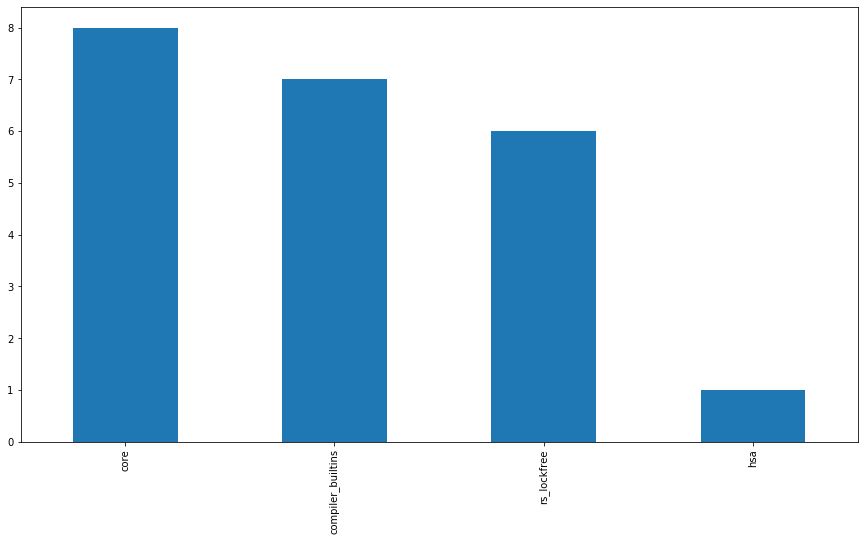

In [22]:
concurrency_intrinsics = set([
    x
    for x in unsafe_block_const_calls.def_path.unique()
    if "core[e667]::intrinsics" in x and "atomic" in x
])
concurrency_intrinsics2 = set([
    x
    for x in unsafe_block_const_calls.summary_key.unique()
    if x.startswith("core.intrinsics.") and "atomic" in x
])
assert len(concurrency_intrinsics2) == len(concurrency_intrinsics)
concurrency_intrinsics_std = set([
    x
    for x in unsafe_block_const_calls.summary_key.unique()
    if x.startswith("std.intrinsics.") and "atomic" in x
])
assert len(concurrency_intrinsics_std) == 0, "We expect all intrinsics in std to be reexports."
print("concurrency_intrinsics:", len(concurrency_intrinsics))

values = unsafe_block_const_calls[
    unsafe_block_const_calls.def_path.isin(concurrency_intrinsics)
].package_name.value_counts()
values.plot.bar()
print(values)
del values

## Use Case 5: Foreign Functions

### Query 12

> we count *how many types are equipped with #[repr(C)]*.

#### Results from the paper for comparison

> Out of 1,486,978 definitions of structures and enumerations, we found that only 3.9% are
annotated with `#[repr(C)]`. This annotation is used in 6.2% of all crates.


all defs: 1486978
False    1428884
True       58094
Name: c_repr, dtype: int64
False    96.09315
True      3.90685
Name: c_repr, dtype: float64


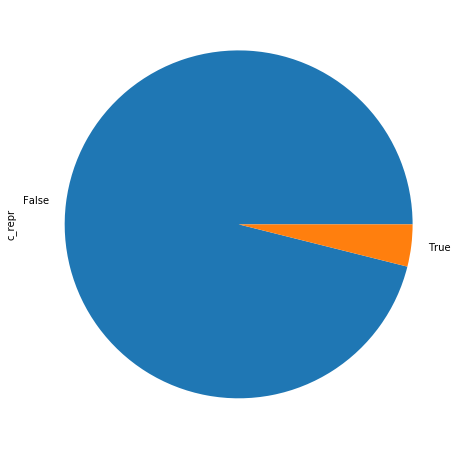

In [23]:
values = adts.c_repr.value_counts()
print("all defs:", len(adts))
print(values)
print(values/len(adts)*100)
values.plot.pie()
del values

In [24]:
values = adts[["c_repr", "crate_hash"]].groupby("crate_hash").agg(sum)
print("Number of crates with C-repr types:", len(values[values.c_repr > 0]))
#print(values[values.c_repr > 0])
print("Percentage:", 100 * len(values[values.c_repr > 0]) / len(selected_builds))
del values

Number of crates with C-repr types: 1987
Percentage: 6.235290425832366


### Query 13

> We thus classify *all -sys crates* as belonging to this use case.

#### Results from the paper for comparison

> We found 650 crates (2.0% of all crates) whose names end with -sys, but we also noticed that other crates
use different naming conventions: for 24 crates the name ends with -ffi, for 13 with -bindings,
and for 10 with -bindgen. These suffixes all clearly mark a crate that provides public bindings to
C libraries, as -sys crates should do.

In [25]:
def count_with_suffix(suffix):
    count = len([
        x
        for x in selected_builds.crate
        if x.lower().replace("-", "_").endswith(suffix)
    ])
    print("There are {} crates with suffix {} ({:.1f}% of all crates)".format(
        count, suffix, 100*count/len(selected_builds)
    ))
count_with_suffix("_sys")
count_with_suffix("_ffi")
count_with_suffix("_bindings")
count_with_suffix("_bindgen")

There are 650 crates with suffix _sys (2.0% of all crates)
There are 24 crates with suffix _ffi (0.1% of all crates)
There are 13 crates with suffix _bindings (0.0% of all crates)
There are 10 crates with suffix _bindgen (0.0% of all crates)


### Query 14

> we determine *how many unsafe functions are declared with a foreign ABI*.

#### Results from the paper for comparison

> We found that 248,522 (44.6%) outof 557,380 unsafe function definitions are actually static bindings to foreign items.

Rust           300563
ForeignItem    248522
C                8268
system             23
sysv64              2
win64               1
efiapi              1
Name: abi, dtype: int64
Rust           53.924253
ForeignItem    44.587535
C               1.483369
system          0.004126
sysv64          0.000359
win64           0.000179
efiapi          0.000179
Name: abi, dtype: float64
Unsafe function definitions: 557380


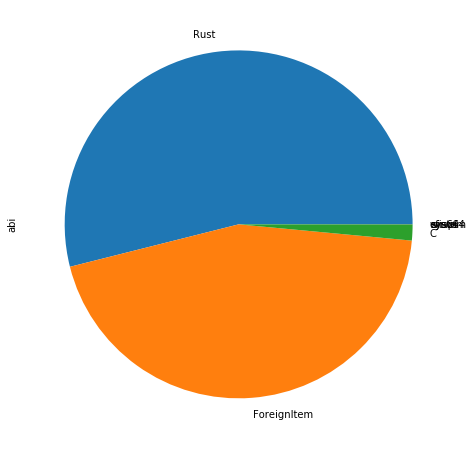

In [26]:
# Frequency of abi
values = unsafe_function_definitions.abi.value_counts()
print(values)
print(values / len(unsafe_function_definitions) * 100)
print("Unsafe function definitions:", len(unsafe_function_definitions))
values.plot.pie()
del values

#### Results from the paper for comparison

> Overall, 1,599 crates (5.0% of all crates) contain at least one function with a foreign ABI.

In [27]:
# Count non-Rust abi functions, per crate
values = unsafe_function_definitions[unsafe_function_definitions.abi != "Rust"].build.value_counts()
print("Number of crates:", len(values))
print("Percentage:", 100*len(values)/len(selected_builds))
print()
# print("Such functions per crate:")
# print(values)
del values

Number of crates: 1599
Percentage: 5.017729940063388



### Query 15

> we search for *usages of inline assembly* via the asm! macro.

#### Results from the paper for comparison

> Out of more than 7 million function definitions we only found 493 cases of functions that use assembly. In particular, we found that 10 low-level and hardware-related crates actually contain 69.8% of all the functions that make use of inline assembly.

In [28]:
# Count functions with assembly code, per crate
asm_fns = function_unsafe_reasons[function_unsafe_reasons["use of inline assembly"]]
print("Number of functions using inline assembly:", len(asm_fns))
assert len(asm_fns) > 100
values = asm_fns[['crate_name', 'crate_hash']].apply(
    lambda row: (row['crate_name'], row['crate_hash']), axis=1
).squeeze().value_counts()
print("Number of crates:", len(values))
print()
print('Percentage of functions with inline assembly among 10 top crates:', sum(values[:10])/len(asm_fns)*100)
print("Such functions per crate:")
print(values[:10])
del values

Number of functions using inline assembly: 493
Number of crates: 56

Percentage of functions with inline assembly among 10 top crates: 69.77687626774848
Such functions per crate:
((intel_tsx_hle), (f1fe356b4269d6a6))       96
((x86), (af30b2093c683d5a))                 75
((mips), (3c6797e99ba2e617))                44
((x86_64), (7dcc58e18846a125))              35
((libvmm), (4733af662f1cad48))              25
((drone_cortex_m), (e4542867d6ea5dfb))      23
((raw_syscall_base), (aa99fa700b6e9ac1))    14
((core), (9e5d89f6bf45f768))                13
((core_arch), (e774ed29d6f42e6e))           12
((linux), (145ed0d096167561))                7
dtype: int64


## Does a crate avoid runtime checks through unchecked functions? 

## Use Case 6: Performance

### Query 16

> we *search for unchecked functions* (those with "unchecked" in their name).

#### Results from the paper for comparison

> we found that 0.6% of all calls to unsafe functions involve unchecked functions spread across 5.7% of all crates.

> For example, the Rust bindings of the X Window System call 4,852 unchecked functions in a single crate.

In [29]:
all_calls = utils.load_all_calls()

In [30]:
unsafe_calls = all_calls.query("unsafety != 'Normal'")
assert len(pd.unique(unsafe_calls.unsafety)) == 1

In [31]:
print("unchecked_function_names:", len(unchecked_function_names))

unchecked_calls = unsafe_block_const_calls[
    unsafe_block_const_calls.def_path.isin(unchecked_function_names)
]
print("Calls to unchecked functions:", len(unchecked_calls))
print("Percentage:", len(unchecked_calls)/len(unsafe_calls)*100)

values = unchecked_calls[['crate_callsite', 'build_crate_hash']].apply(
    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
).squeeze().value_counts()
print("Number of crates:", len(values))
print("Percentage:", len(values)/len(selected_builds)*100)
print(values[:5])

# Used in Sec. 6.2
print("Percentage of unsafe blocks with an unchecked function call:",
    len(unchecked_calls.unsafe_scope.unique())/len(unsafe_block_const_calls.unsafe_scope.unique())*100
)
del values

unchecked_function_names: 7570
Calls to unchecked functions: 31585
Percentage: 0.6489489328452399
Number of crates: 1801
Percentage: 5.65161452286064
(x11_keysymdef, 1077887af1a49fbc)    4852
(http_box, c33bb5cc8ef0afa3)         1017
(nalgebra, c385ef8b70792688)          815
(qt_widgets, 1a3b2d4a7792803)         696
(packed_simd, b423b7f8b21d99d7)       614
dtype: int64
Percentage of unsafe blocks with an unchecked function call: 4.1664199823633705


### Query 17

> we determine whether *unsafe blocks contain the special union type MaybeUninit*

#### Results from the paper for comparison

> Developers rarely use the union MaybeUninit, which allows declaring uninitialised variables:
We detected it in only 1,816 unsafe blocks, which appear in 0.55% of all crates.

In [32]:
assume_init_def_path = "core[e667]::mem[0]::maybe_uninit[0]::{{impl}}[2]::assume_init[0]"
assume_init_summary_key = 'core.mem.maybe_uninit.implement_maybe_uninit.assume_init'

values = unsafe_block_const_calls[
    unsafe_block_const_calls.def_path == assume_init_def_path
].package_name.value_counts()
values_summary = unsafe_block_const_calls[
    unsafe_block_const_calls.summary_key == assume_init_summary_key
].package_name.value_counts()
assert len(values) == len(values_summary)
print("Number of crates:", len(values))
print("Percentage:", len(values)/len(selected_builds)*100)
# print(values)
print("Number of calls:", sum(values))
del values
del values_summary

Number of crates: 174
Percentage: 0.5460193931025826
Number of calls: 1816
